In [2]:
# STEP 1 — Write kaggle.json from creds + download Kaggle Iris dataset (multiclass)

import os, sys, shutil, zipfile, subprocess, textwrap, pathlib, json

# ==== FILL THESE FROM YOUR kaggle.json (Kaggle > Account > Create New API Token) ====
KAGGLE_USERNAME = "iamvijayshankar"   # e.g., "anjalijha1507"
KAGGLE_KEY      = "5432ac578dbd76cbbfa10a1935b6e4aa"        # long secret string from kaggle.json
# ================================================================================

KAGGLE_DATASET = "uciml/iris"                      # Multiclass: setosa / versicolor / virginica
DATA_ROOT      = os.path.abspath("./data")
DATASET_DIR    = os.path.join(DATA_ROOT, "iris_kaggle")

print("KAGGLE_DATASET:", KAGGLE_DATASET)
print("DATA_ROOT:", DATA_ROOT)
print("DATASET_DIR:", DATASET_DIR)

# 1) Ensure kaggle CLI is installed
subprocess.run([sys.executable, "-m", "pip", "install", "-q", "kaggle"], check=True)

# 2) Create ~/.kaggle/kaggle.json from creds above
home = str(pathlib.Path.home())
kaggle_dir = os.path.join(home, ".kaggle")
kaggle_json_path = os.path.join(kaggle_dir, "kaggle.json")
os.makedirs(kaggle_dir, exist_ok=True)

if not KAGGLE_USERNAME or not KAGGLE_KEY:
    raise ValueError("Please fill KAGGLE_USERNAME and KAGGLE_KEY above (from your kaggle.json).")

with open(kaggle_json_path, "w") as f:
    json.dump({"username": KAGGLE_USERNAME, "key": KAGGLE_KEY}, f)
try:
    os.chmod(kaggle_json_path, 0o600)
except Exception:
    pass

# Also set env vars (Kaggle CLI can use these)
os.environ["KAGGLE_USERNAME"] = KAGGLE_USERNAME
os.environ["KAGGLE_KEY"] = KAGGLE_KEY

# 3) Make local folders
os.makedirs(DATA_ROOT, exist_ok=True)
os.makedirs(DATASET_DIR, exist_ok=True)

# 4) Download dataset zip to DATA_ROOT
print("\nDownloading from Kaggle…")
subprocess.run([
    "kaggle", "datasets", "download",
    "-d", KAGGLE_DATASET,
    "-p", DATA_ROOT,
    "--force"
], check=True)

# 5) Unzip all zips into DATASET_DIR
for fname in os.listdir(DATA_ROOT):
    if fname.lower().endswith(".zip"):
        zpath = os.path.join(DATA_ROOT, fname)
        print("Unzipping:", zpath)
        with zipfile.ZipFile(zpath, "r") as zf:
            zf.extractall(DATASET_DIR)
        os.remove(zpath)

print("\nContents of dataset directory:")
for f in os.listdir(DATASET_DIR):
    print(" -", f)

KAGGLE_DATASET: uciml/iris
DATA_ROOT: /Users/spartan/Documents/data
DATASET_DIR: /Users/spartan/Documents/data/iris_kaggle

Dataset URL: https://www.kaggle.com/datasets/uciml/iris
License(s): CC0-1.0

Unzipping: /Users/spartan/Documents/data/iris.zip

Contents of dataset directory:
 - database.sqlite
 - Iris.csv


100%|██████████| 3.60k/3.60k [00:00<00:00, 7.73MB/s]


In [3]:
# STEP 2 — Load Iris CSV, sanity checks, label encoding, stratified split

import os, glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Paths must match Step 1
DATA_ROOT   = os.path.abspath("./data")
DATASET_DIR = os.path.join(DATA_ROOT, "iris_kaggle")

# 2.1 Find the CSV (handles Iris.csv / iris.csv)
candidates = glob.glob(os.path.join(DATASET_DIR, "*.csv"))
if not candidates:
    raise FileNotFoundError(f"No CSV found in {DATASET_DIR}. Found: {os.listdir(DATASET_DIR)}")
CSV_PATH = candidates[0]
print("Loaded file:", os.path.basename(CSV_PATH))

# 2.2 Read
df = pd.read_csv(CSV_PATH)
print("Shape:", df.shape)
display(df.head())

# 2.3 Basic checks
print("\nColumns:", list(df.columns))
print("\nMissing per column:\n", df.isna().sum())
print("\nDuplicate rows (before drop):", df.duplicated().sum())

# Drop duplicates if any
if df.duplicated().any():
    df = df.drop_duplicates().reset_index(drop=True)
    print("Duplicates removed. New shape:", df.shape)

# 2.4 Identify target column robustly (usually 'Species')
possible_targets = [c for c in df.columns if c.lower() == "species"]
if not possible_targets:
    raise ValueError(f"Could not find target column 'Species'. Columns: {list(df.columns)}")
TARGET = possible_targets[0]

# 2.5 Drop obvious ID column if present
for id_col in ["Id", "id", "index"]:
    if id_col in df.columns:
        df.drop(columns=[id_col], inplace=True)

# 2.6 Separate features and label
y_raw = df[TARGET].astype(str)
X = df.drop(columns=[TARGET])

# 2.7 Encode labels to integers for multiclass models (keep mapping for later)
le = LabelEncoder()
y = le.fit_transform(y_raw)
classes = list(le.classes_)
label_map = {i: cls for i, cls in enumerate(classes)}
print("\nLabel mapping:", label_map)

# 2.8 Stratified train/validation split
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain: {X_train.shape} | Valid: {X_valid.shape}")
print("Class balance (train):", np.bincount(y_train) / len(y_train))
print("Class balance (valid):", np.bincount(y_valid) / len(y_valid))

Loaded file: Iris.csv
Shape: (150, 6)


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa



Columns: ['Id', 'SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm', 'Species']

Missing per column:
 Id               0
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

Duplicate rows (before drop): 0

Label mapping: {0: 'Iris-setosa', 1: 'Iris-versicolor', 2: 'Iris-virginica'}

Train: (120, 4) | Valid: (30, 4)
Class balance (train): [0.33333333 0.33333333 0.33333333]
Class balance (valid): [0.33333333 0.33333333 0.33333333]


Baseline LogisticRegression — Accuracy: 0.933 | Macro-F1: 0.933

Classification report:
                  precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.90      0.90      0.90        10
 Iris-virginica       0.90      0.90      0.90        10

       accuracy                           0.93        30
      macro avg       0.93      0.93      0.93        30
   weighted avg       0.93      0.93      0.93        30



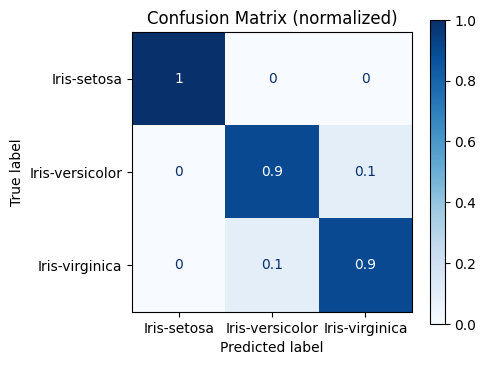

In [4]:
# STEP 3 — Baseline Multiclass Model (Logistic Regression) + Metrics & Confusion Matrix

import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay

# 3.1 Build baseline pipeline:
# Impute (safety) -> Scale -> Multinomial Logistic Regression (softmax)
baseline_clf = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()),
    ("logit", LogisticRegression(max_iter=1000, multi_class="auto"))
])

# 3.2 Fit on training data
baseline_clf.fit(X_train, y_train)

# 3.3 Predict on validation
y_pred = baseline_clf.predict(X_valid)

# 3.4 Evaluate
acc = accuracy_score(y_valid, y_pred)
f1m = f1_score(y_valid, y_pred, average="macro")
print(f"Baseline LogisticRegression — Accuracy: {acc:.3f} | Macro-F1: {f1m:.3f}\n")
print("Classification report:\n", classification_report(y_valid, y_pred, target_names=classes))

# 3.5 Confusion matrix (normalized)
fig, ax = plt.subplots(figsize=(5,4))
ConfusionMatrixDisplay.from_predictions(
    y_valid, y_pred,
    display_labels=classes,
    normalize="true",
    cmap="Blues",
    ax=ax
)
ax.set_title("Confusion Matrix (normalized)")
plt.tight_layout()
plt.show()

# Keep for comparison in next step
baseline_model = baseline_clf

RandomForest — Accuracy: 0.933 | Macro-F1: 0.933

RF Classification report:
                  precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.90      0.90      0.90        10
 Iris-virginica       0.90      0.90      0.90        10

       accuracy                           0.93        30
      macro avg       0.93      0.93      0.93        30
   weighted avg       0.93      0.93      0.93        30


=== Validation Metrics (Side-by-Side) ===
LogisticRegression -> ACC: 0.933 | Macro-F1: 0.933
RandomForest       -> ACC: 0.933 | Macro-F1: 0.933


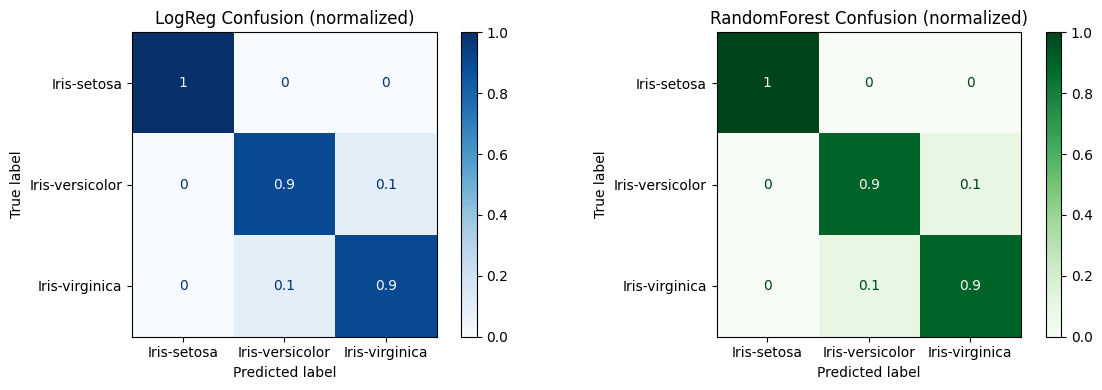

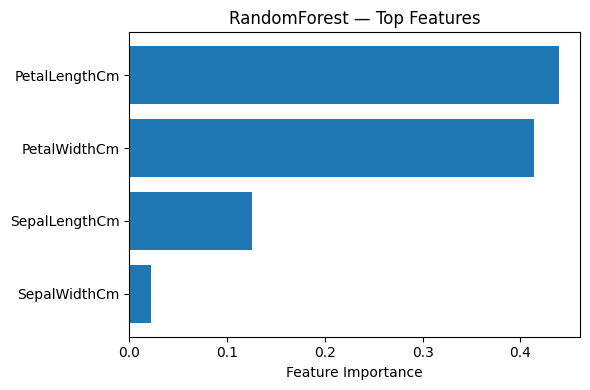


Best model selected for next step: RandomForest


In [5]:
# STEP 4 — Stronger model (RandomForest) + side-by-side comparison + feature importance

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay

# 4.1 Fit a Random Forest (good for non-linear patterns on tabular data)
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# 4.2 Evaluate RF
y_pred_rf = rf.predict(X_valid)
acc_rf = accuracy_score(y_valid, y_pred_rf)
f1m_rf = f1_score(y_valid, y_pred_rf, average="macro")
print(f"RandomForest — Accuracy: {acc_rf:.3f} | Macro-F1: {f1m_rf:.3f}")
print("\nRF Classification report:\n", classification_report(y_valid, y_pred_rf, target_names=classes))

# 4.3 Evaluate baseline again for side-by-side numbers
y_pred_bl = baseline_model.predict(X_valid)
acc_bl = accuracy_score(y_valid, y_pred_bl)
f1m_bl = f1_score(y_valid, y_pred_bl, average="macro")

print("\n=== Validation Metrics (Side-by-Side) ===")
print(f"LogisticRegression -> ACC: {acc_bl:.3f} | Macro-F1: {f1m_bl:.3f}")
print(f"RandomForest       -> ACC: {acc_rf:.3f} | Macro-F1: {f1m_rf:.3f}")

# 4.4 Confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ConfusionMatrixDisplay.from_predictions(
    y_valid, y_pred_bl, display_labels=classes, normalize="true", cmap="Blues", ax=ax[0]
)
ax[0].set_title("LogReg Confusion (normalized)")
ConfusionMatrixDisplay.from_predictions(
    y_valid, y_pred_rf, display_labels=classes, normalize="true", cmap="Greens", ax=ax[1]
)
ax[1].set_title("RandomForest Confusion (normalized)")
plt.tight_layout()
plt.show()

# 4.5 Feature importance (top 8)
importances = rf.feature_importances_
feat_names = X_train.columns
idx = np.argsort(importances)[::-1][:8]

plt.figure(figsize=(6, 4))
plt.barh(range(len(idx)), importances[idx][::-1])
plt.yticks(range(len(idx)), [feat_names[i] for i in idx][::-1])
plt.xlabel("Feature Importance")
plt.title("RandomForest — Top Features")
plt.tight_layout()
plt.show()

# 4.6 Pick the current best model for the next step
best_model = rf if f1m_rf >= f1m_bl else baseline_model
print("\nBest model selected for next step:", "RandomForest" if best_model is rf else "LogisticRegression")